# Reinforcement Learning with Imitation Learning and Self-Play

The complete workflow for training a Lunar Lander agent using:
1. Expert DQN training
2. Expert trajectory generation
3. Behavioral Cloning
4. DAgger (Dataset Aggregation)
5. Self-Play enhancement
6. Comprehensive evaluation

We'll be using the LunarLander-v3 environment from Gymnasium.

## 1. Setup and Installation

In [1]:
!pip uninstall -y gymnasium box2d-py
# 1. Install swig (required for Box2D bindings)
!apt-get install -y swig

# 2. Clone and install box2d-py from source using a patched version
!git clone https://github.com/openai/box2d-py
%cd box2d-py
!pip install -e .

# 3. Go back and install gymnasium with box2d extra (skip box2d install here)
%cd ..
!pip install gymnasium[box2d] --no-deps

Found existing installation: gymnasium 1.1.1
Uninstalling gymnasium-1.1.1:
  Successfully uninstalled gymnasium-1.1.1
Found existing installation: box2d-py 2.3.8
Uninstalling box2d-py-2.3.8:
  Successfully uninstalled box2d-py-2.3.8
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
fatal: destination path 'box2d-py' already exists and is not an empty directory.
/content/box2d-py
Obtaining file:///content/box2d-py
  Preparing metadata (setup.py) ... done
  Running setup.py develop for box2d-py
/content
  Using cached gymnasium-1.1.1-py3-none-any.whl.metadata (9.4 kB)
Using cached gymnasium-1.1.1-py3-none-any.whl (965 kB)


In [2]:
!pip install torch matplotlib numpy tqdm

In [3]:
# Import common libraries used throughout the notebook
import os
import torch
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import pickle
from collections import namedtuple, deque
from itertools import count
from tqdm.notebook import tqdm

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

Using device: cuda


## 2. Define DQN Architecture

First, let's define the neural network architecture for our DQN agent.

In [4]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## 3. DQN Expert Training

Here we'll train our expert DQN model on the LunarLander environment.

In [5]:
# Define parameters
num_episodes = 600  # Set to a lower value like 50 for testing
batch_size = 128
GAMMA = 0.99
LR = 1e-4
TAU = 0.005

EPSILON = 1.0  # Start with full exploration
EPSILON_MIN = 0.01  # Minimum value
EPSILON_DECAY = 0.995  # Decay factor per episode

reward_list = []
episode_durations = []

# Define Transition namedtuple
Transition = namedtuple("Transition", ["state", "action", "next_state", "reward", "done"])

# Define Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return (
            random.sample(self.memory, batch_size)
            if batch_size < len(self.memory)
            else self.memory
        )

    def __len__(self):
        return len(self.memory)

In [6]:
# Initialize the environment
env = gym.make("LunarLander-v3")

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

replay_memory = ReplayMemory(10000)

def select_action(state, epsilon):
    if random.random() < epsilon:
        return torch.tensor(
            [[env.action_space.sample()]], dtype=torch.long, device=device
        )
    else:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)  # Exploit (best action)

optimizer = optim.AdamW(policy_net.parameters(), lr=LR)
criterion = nn.SmoothL1Loss()

In [7]:
# Train the expert DQN
print("Training Expert DQN...")

# Enable this line to use tqdm for progress tracking
for episode in tqdm(range(num_episodes), desc="Training Episodes"):
#for episode in range(num_episodes):  # Alternative without tqdm
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0

    for t in count():
        action = select_action(state, EPSILON)
        next_state, reward, terminated, truncated, info = env.step(action.item())

        done = terminated or truncated
        reward = torch.tensor([reward], device=device)
        next_state = torch.tensor(
            next_state, dtype=torch.float32, device=device
        ).unsqueeze(0)
        replay_memory.push(state, action, next_state, reward, done)

        state = next_state
        total_reward += reward.item()

        if len(replay_memory) >= batch_size:
            transitions = replay_memory.sample(batch_size)
            states, actions, next_states, rewards, dones = zip(*transitions)

            states_batch = torch.cat(states)
            next_states_batch = torch.cat(next_states)
            actions_batch = torch.cat(actions)
            rewards = torch.tensor(rewards, device=device)
            dones = torch.tensor(dones, device=device)

            q_target = (
                GAMMA * target_net(next_states_batch).detach().max(1)[0] * ~dones
                + rewards
            )
            q_policy = policy_net(states_batch).gather(1, actions_batch)

            # Calculate the Huber loss
            loss = criterion(q_policy, q_target.unsqueeze(1))

            # Optimize the model
            optimizer.zero_grad()
            loss.backward()

            # In-place gradient clipping to stabilize training
            torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)

            optimizer.step()

        # Update target network
        for target_param, main_param in zip(
            target_net.parameters(), policy_net.parameters()
        ):
            target_param.data.copy_(
                TAU * main_param.data + (1 - TAU) * target_param.data
            )

        if done:
            episode_durations.append(t + 1)
            reward_list.append(total_reward)
            break

    # Decay epsilon
    EPSILON = max(EPSILON_MIN, EPSILON * EPSILON_DECAY)

    # Print progress occasionally
    if episode % 10 == 0:
        avg_reward = np.mean(reward_list[-10:]) if reward_list else 0
        print(f"Episode {episode}/{num_episodes}, Avg Reward: {avg_reward:.2f}, Epsilon: {EPSILON:.2f}")

# Save the trained model
torch.save(policy_net.state_dict(), "models/dqn_lunar_lander.pth")
print("Expert DQN model saved successfully!")

Training Expert DQN...


Training Episodes:   0%|          | 0/600 [00:00<?, ?it/s]

Episode 0/600, Avg Reward: -113.39, Epsilon: 0.99
Episode 10/600, Avg Reward: -167.23, Epsilon: 0.95
Episode 20/600, Avg Reward: -161.95, Epsilon: 0.90
Episode 30/600, Avg Reward: -87.41, Epsilon: 0.86
Episode 40/600, Avg Reward: -121.12, Epsilon: 0.81
Episode 50/600, Avg Reward: -74.62, Epsilon: 0.77
Episode 60/600, Avg Reward: -81.70, Epsilon: 0.74
Episode 70/600, Avg Reward: -79.55, Epsilon: 0.70
Episode 80/600, Avg Reward: -72.69, Epsilon: 0.67
Episode 90/600, Avg Reward: -32.76, Epsilon: 0.63
Episode 100/600, Avg Reward: -42.93, Epsilon: 0.60
Episode 110/600, Avg Reward: -40.49, Epsilon: 0.57
Episode 120/600, Avg Reward: -48.69, Epsilon: 0.55
Episode 130/600, Avg Reward: -47.68, Epsilon: 0.52
Episode 140/600, Avg Reward: -13.56, Epsilon: 0.49
Episode 150/600, Avg Reward: -22.18, Epsilon: 0.47
Episode 160/600, Avg Reward: -0.31, Epsilon: 0.45
Episode 170/600, Avg Reward: -25.43, Epsilon: 0.42
Episode 180/600, Avg Reward: -5.70, Epsilon: 0.40
Episode 190/600, Avg Reward: 0.09, Epsil

## 4. Generate Expert Trajectories

Let's generate and save expert trajectories using our trained DQN model.

In [8]:
# Create video folder for recordings
video_folder = "./dqn_expert_videos/"
os.makedirs(video_folder, exist_ok=True)

# Load the expert model
expert_policy = DQN(n_observations, n_actions).to(device)
expert_policy.load_state_dict(torch.load("models/dqn_lunar_lander.pth", map_location=device))
expert_policy.eval()

# Configure environment for video recording
env = gym.make("LunarLander-v3", render_mode="rgb_array")
env = gym.wrappers.RecordVideo(
    env,
    video_folder,
    episode_trigger=lambda ep: ep < 2,  # Save first 2 episodes
    name_prefix="dqn_expert"
)

# Generate expert trajectories
expert_trajectories = []
n_episodes = 5

print("Generating expert trajectories...")
for episode in range(n_episodes):
    state, _ = env.reset()
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    trajectory = {"obs": [], "actions": [], "rewards": []}
    total_reward = 0

    for t in count():
        with torch.no_grad():
            action = expert_policy(state_tensor).argmax(dim=1).item()

        next_state, reward, terminated, truncated, _ = env.step(action)

        trajectory["obs"].append(state)
        trajectory["actions"].append(action)
        trajectory["rewards"].append(reward)

        total_reward += reward
        done = terminated or truncated
        if done:
            break

        state = next_state
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    expert_trajectories.append(trajectory)
    print(f"Episode {episode + 1}/{n_episodes} | Total reward: {total_reward:.2f}")

env.close()
print(f"Saved videos to: {video_folder}")

# Save expert trajectories
with open('expert_trajectories.pkl', 'wb') as f:
    pickle.dump(expert_trajectories, f)
print("Expert trajectories saved!")

Generating expert trajectories...


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/dqn_expert_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 1/5 | Total reward: 260.74
Episode 2/5 | Total reward: 234.83
Episode 3/5 | Total reward: 227.04
Episode 4/5 | Total reward: 299.23
Episode 5/5 | Total reward: 250.97
Saved videos to: ./dqn_expert_videos/
Expert trajectories saved!


## 5. Behavioral Cloning

Train a student model to mimic the expert's behavior.

In [ ]:
# Load expert trajectories
with open('expert_trajectories.pkl', 'rb') as f:
    expert_trajectories = pickle.load(f)

# Create Student Model (same architecture as DQN but fresh weights)
env = gym.make("LunarLander-v3")
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

student_model = DQN(n_observations, n_actions).to(device)
optimizer = optim.Adam(student_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Prepare dataset from expert trajectories
states = []
actions = []
for trajectory in expert_trajectories:
    states.extend(trajectory['obs'])
    actions.extend(trajectory['actions'])

states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
actions = torch.tensor(actions, dtype=torch.long).to(device)

# Training loop
epochs = 100
batch_size = 64
dataset_size = len(states)

print("Training student model with Behavioral Cloning...")
for epoch in tqdm(range(epochs), desc="BC Training"):
    # Shuffle data
    indices = torch.randperm(dataset_size)
    total_loss = 0.0
    batches = 0

    for start_idx in range(0, dataset_size, batch_size):
        # Get batch indices
        batch_indices = indices[start_idx:start_idx + batch_size]

        # Get batch data
        state_batch = states[batch_indices]
        action_batch = actions[batch_indices]

        # Forward pass
        logits = student_model(state_batch)
        loss = criterion(logits, action_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batches += 1

    avg_loss = total_loss / batches
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Save the imitation learning model
torch.save(student_model.state_dict(), "models/imitation_model.pth")
print("Behavioral Cloning model saved successfully!")

## 6. DAgger (Dataset Aggregation)

Use DAgger to improve the student model by aggregating additional expert-labeled data.

In [10]:
# Load the expert and student models
env = gym.make("LunarLander-v3")
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

# Expert
expert_model = DQN(n_observations, n_actions).to(device)
expert_model.load_state_dict(torch.load("models/dqn_lunar_lander.pth", map_location=device))
expert_model.eval()

# Student (initially from behavioral cloning)
student_model = DQN(n_observations, n_actions).to(device)
student_model.load_state_dict(torch.load("models/imitation_model.pth", map_location=device))

# Try to load existing dataset or create new one
try:
    with open('dagger_dataset.pkl', 'rb') as f:
        dataset = pickle.load(f)
        print("Loaded existing DAgger dataset")
except FileNotFoundError:
    # Start with expert trajectories
    with open('expert_trajectories.pkl', 'rb') as f:
        expert_trajectories = pickle.load(f)

    # Convert to dataset format
    dataset = {'states': [], 'actions': []}
    for traj in expert_trajectories:
        dataset['states'].extend(traj['obs'])
        dataset['actions'].extend(traj['actions'])
    print("Created new DAgger dataset from expert trajectories")

# DAgger parameters
n_dagger_iterations = 5
n_episodes_per_iteration = 10
epochs_per_iteration = 20
batch_size = 64

optimizer = optim.Adam(student_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Created new DAgger dataset from expert trajectories


In [ ]:
# DAgger training loop
print("Starting DAgger training...")
for dagger_iter in range(n_dagger_iterations):
    print(f"\nDAgger Iteration {dagger_iter+1}/{n_dagger_iterations}")

    # Collect data with student policy, but label with expert
    for episode in tqdm(range(n_episodes_per_iteration), desc="Collecting data"):
        state, _ = env.reset()
        done = False

        while not done:
            # Student collects state
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            # Student takes action
            with torch.no_grad():
                student_action = student_model(state_tensor).argmax(dim=1).item()

            # Expert labels the state
            with torch.no_grad():
                expert_action = expert_model(state_tensor).argmax(dim=1).item()

            # Add to dataset with expert label
            dataset['states'].append(state)
            dataset['actions'].append(expert_action)

            # Execute student's action to get next state
            next_state, _, terminated, truncated, _ = env.step(student_action)
            done = terminated or truncated
            state = next_state

    # Convert to tensors
    states = torch.tensor(np.array(dataset['states']), dtype=torch.float32).to(device)
    actions = torch.tensor(dataset['actions'], dtype=torch.long).to(device)

    # Train student on aggregated dataset
    dataset_size = len(states)
    print(f"Training on aggregated dataset of size {dataset_size}...")

    for epoch in tqdm(range(epochs_per_iteration), desc="Training"):
        # Shuffle data
        indices = torch.randperm(dataset_size)
        total_loss = 0.0
        batches = 0

        for start_idx in range(0, dataset_size, batch_size):
            # Get batch indices
            batch_indices = indices[start_idx:start_idx + batch_size]

            # Get batch data
            state_batch = states[batch_indices]
            action_batch = actions[batch_indices]

            # Forward pass
            logits = student_model(state_batch)
            loss = criterion(logits, action_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batches += 1

        if epoch % 5 == 0:
            avg_loss = total_loss / batches
            print(f"  Epoch {epoch+1}/{epochs_per_iteration}, Loss: {avg_loss:.4f}")

    # Save the updated model
    torch.save(student_model.state_dict(), f"models/dagger_model_iter{dagger_iter+1}.pth")

    # Save the dataset
    with open('dagger_dataset.pkl', 'wb') as f:
        pickle.dump(dataset, f)

print("DAgger training complete!")

## 7. Self-Play Enhancement

Further improve the model through self-play reinforcement learning.

In [12]:
# Parameters
MEMORY_SIZE = 100000
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.005
LR = 0.0001
N_ITERATIONS = 20  # Reduced from 50 for notebook execution time
EPISODES_PER_ITER = 10  # Reduced from 20 for notebook execution time

# Start with the best model so far
best_model = DQN(n_observations, n_actions).to(device)
try:
    # Try to load the DAgger model first
    model_path = "models/dagger_model_iter5.pth"
    if not os.path.exists(model_path):
        model_path = "models/imitation_model.pth"
    if not os.path.exists(model_path):
        model_path = "models/dqn_lunar_lander.pth"

    best_model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Loaded initial model from {model_path}")
except:
    print("Starting with a fresh model")

# Create target model
target_model = DQN(n_observations, n_actions).to(device)
target_model.load_state_dict(best_model.state_dict())
target_model.eval()

# Memory for self-play
memory = ReplayMemory(MEMORY_SIZE)

optimizer = optim.Adam(best_model.parameters(), lr=LR)

def evaluate_policy(model, env, episodes=5):
    """Evaluate a policy without exploration"""
    model.eval()
    total_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                action = model(state_tensor).argmax(dim=1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated
            state = next_state
        total_rewards.append(total_reward)
    model.train()
    return np.mean(total_rewards)

Loaded initial model from models/dagger_model_iter5.pth


In [ ]:
# Self-play training
print("Starting self-play training...")
best_reward = evaluate_policy(best_model, env)
print(f"Initial performance: {best_reward:.2f}")

env = gym.make("LunarLander-v3") # No rendering for faster execution

for iteration in range(N_ITERATIONS):
    # Collect experience with current best model
    for episode in tqdm(range(EPISODES_PER_ITER), desc=f"Iteration {iteration+1} data collection"):
        state, _ = env.reset()
        done = False

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            # Epsilon-greedy action selection (with small epsilon)
            if random.random() < 0.05:  # 5% exploration
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = best_model(state_tensor).argmax(dim=1).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store transition
            memory.push(
                state,
                action,
                next_state if not done else None,
                reward,
                done
            )

            state = next_state

    # Train on collected data
    if len(memory) >= BATCH_SIZE:
        print(f"Training on {len(memory)} transitions...")
        for _ in tqdm(range(500), desc="Training"):  # Train for 500 batches
            transitions = memory.sample(BATCH_SIZE)
            batch = Transition(*zip(*transitions))

            non_final_mask = torch.tensor(
                tuple(map(lambda s: s is not None, batch.next_state)),
                device=device, dtype=torch.bool)

            non_final_next_states = torch.tensor(
                np.array([s for s in batch.next_state if s is not None]),
                dtype=torch.float32, device=device)

            state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32, device=device)
            action_batch = torch.tensor(batch.action, device=device).unsqueeze(1)
            reward_batch = torch.tensor(batch.reward, device=device)
            done_batch = torch.tensor(batch.done, device=device, dtype=torch.bool)

            # Compute Q(s_t, a)
            state_action_values = best_model(state_batch).gather(1, action_batch)

            # Compute expected Q values
            next_state_values = torch.zeros(BATCH_SIZE, device=device)
            with torch.no_grad():
                next_state_values[non_final_mask] = target_model(non_final_next_states).max(1)[0]

            expected_state_action_values = (next_state_values * GAMMA * (~done_batch)) + reward_batch

            # Compute loss and optimize
            loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Soft update target network
            for target_param, local_param in zip(target_model.parameters(), best_model.parameters()):
                target_param.data.copy_(TAU * local_param.data + (1.0 - TAU) * target_param.data)

    # Evaluate current policy
    current_reward = evaluate_policy(best_model, env)
    print(f"Iteration {iteration+1}/{N_ITERATIONS}, Reward: {current_reward:.2f}")

    # Save if improved
    if current_reward > best_reward:
        best_reward = current_reward
        torch.save(best_model.state_dict(), f"models/self_play_model_iter{iteration+1}.pth")
        print(f"  Saved improved model with reward {best_reward:.2f}")

print(f"Self-play training complete! Best reward: {best_reward:.2f}")
torch.save(best_model.state_dict(), "models/self_play_best.pth")

## 8. Final Evaluation

Compare all trained models to see which performs best.

In [14]:
# Setup for evaluation
env = gym.make("LunarLander-v3", render_mode="rgb_array")
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

# Load all models to compare
models = {
    "Expert DQN": "models/dqn_lunar_lander.pth",
    "Behavioral Cloning": "models/imitation_model.pth",
    "DAgger": "models/dagger_model_iter5.pth",
    "Self-Play": "models/self_play_best.pth"
}

# Function to evaluate a model
def evaluate_model_with_render(model_path, n_episodes=5):
    model = DQN(n_observations, n_actions).to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
    except Exception as e:
        print(f"Failed to load model: {model_path}, error: {e}")
        return []

    rewards = []
    for i in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                action = model(state_tensor).argmax(dim=1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated
            state = next_state

        rewards.append(total_reward)
        print(f"  Episode {i+1}: {total_reward:.2f}")

    return rewards

In [15]:
# Evaluate all models
results = {}
for name, path in models.items():
    try:
        print(f"Evaluating {name}...")
        rewards = evaluate_model_with_render(path)
        results[name] = rewards
        if rewards:  # Only calculate if we got valid rewards
            print(f"  Mean reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
    except Exception as e:
        print(f"Error evaluating {name}: {e}")

env.close()

Evaluating Expert DQN...
  Episode 1: 212.48
  Episode 2: 261.13
  Episode 3: 280.26
  Episode 4: 282.89
  Episode 5: 173.60
  Mean reward: 242.07 ± 42.55
Evaluating Behavioral Cloning...
  Episode 1: 2.23
  Episode 2: 190.07
  Episode 3: -0.62
  Episode 4: 179.92
  Episode 5: 35.57
  Mean reward: 81.43 ± 85.57
Evaluating DAgger...
  Episode 1: 222.39
  Episode 2: 229.42
  Episode 3: 280.35
  Episode 4: 269.30
  Episode 5: 220.31
  Mean reward: 244.35 ± 25.31
Evaluating Self-Play...
  Episode 1: 253.59
  Episode 2: 212.96
  Episode 3: 265.22
  Episode 4: -159.98
  Episode 5: 105.02
  Mean reward: 135.36 ± 158.12


<ipython-input-16-a5eeb82ccecf>:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([valid_models[name] for name in valid_models.keys()], labels=list(valid_models.keys()))


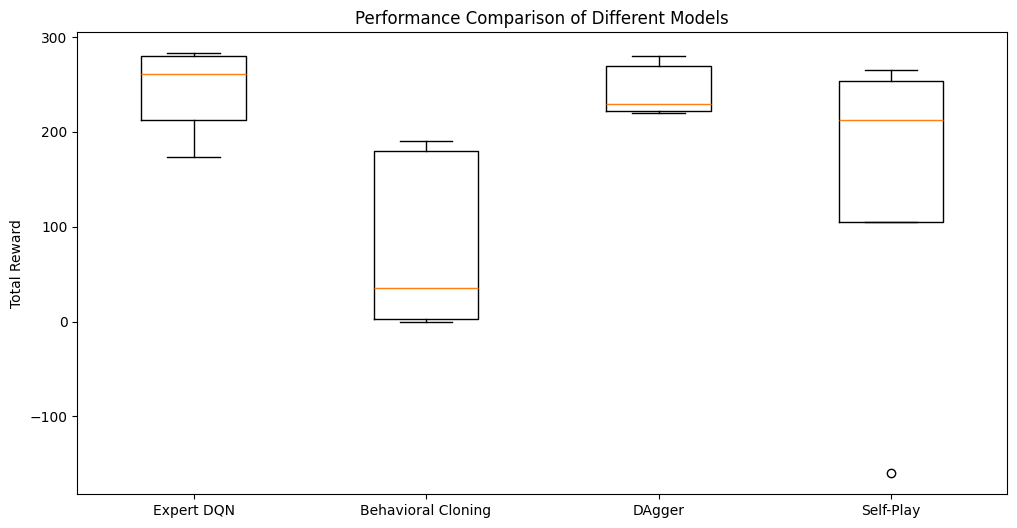


Summary:
Expert DQN: 242.07 ± 42.55
Behavioral Cloning: 81.43 ± 85.57
DAgger: 244.35 ± 25.31
Self-Play: 135.36 ± 158.12


In [16]:
# Plot results
plt.figure(figsize=(12, 6))
valid_models = {name: results[name] for name in results if results[name]}
plt.boxplot([valid_models[name] for name in valid_models.keys()], labels=list(valid_models.keys()))
plt.ylabel('Total Reward')
plt.title('Performance Comparison of Different Models')
plt.savefig('model_comparison.png')
plt.show()

# Print summary
print("\nSummary:")
for name in valid_models:
    rewards = valid_models[name]
    print(f"{name}: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")

## 9. Conclusion

In this notebook, we've implemented a complete reinforcement learning workflow including:

1. Expert DQN training on the LunarLander-v3 environment
2. Generation of expert trajectories from the trained DQN model
3. Behavioral Cloning to create an initial student model from expert demonstrations
4. DAgger (Dataset Aggregation) to improve the student model with additional expert-labeled data
5. Self-Play reinforcement learning to further refine the model
6. Evaluation and comparison of all approaches

This combined approach leverages both imitation learning (learning from expert demonstrations) and reinforcement learning (learning from experience) to create a robust agent that can effectively solve the lunar landing task.